# Rainfall Prediction Model

This notebook implements a rainfall prediction model with:
- **Data**: Half of 'data/train.csv' combined with 'data/rainfall_transformed.csv' for training; other half for validation.
- **Options**: 
  - `use_smote` (default True): Toggle SMOTE.
  - `voting_method` (default 'weighted'): Weighted soft voting or hard voting.
- **Models**:
  - XGBoost, Random Forest, LightGBM, and K-Means (predictive model with 2 clusters).
  - Calibrated probabilities for XGBoost, RF, and LGB.
  - Prediction correlation analysis.
- **Output**: Predictions saved as 'submission_<method>_<timestamp>.csv'.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from scipy.stats import rankdata, spearmanr
from imblearn.over_sampling import SMOTE
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

# Configuration
USE_SMOTE = True
VOTING_METHOD = 'weighted'

# Load and split data
train_full = pd.read_csv('data/train.csv')
train_transformed = pd.read_csv('data/rainfall_transformed.csv')
test = pd.read_csv('data/test.csv')

# Split train.csv
train_half = train_full.sample(frac=0.5, random_state=42)
val = train_full.drop(train_half.index)

# Combine for training
train = pd.concat([train_transformed, train_half], ignore_index=True)

## Feature Engineering

Add new features (K-Means used as a model, not a feature).

In [2]:
# Feature engineering
for df in [train, val, test]:
    df['temp_change_rate'] = df['temparature'].diff().fillna(0)
    df['humidity_change_trend'] = df['humidity'].diff().fillna(0)
    df['pressure_change'] = df['pressure'].diff().fillna(0)
    df['windspeed_change'] = df['windspeed'].diff().fillna(0)
    df['temp_range'] = df['maxtemp'] - df['mintemp']
    df['humidity_temp_ratio'] = df['humidity'] / (df['temparature'] + 0.1)
    df['wind_pressure_interaction'] = df['windspeed'] * df['pressure'] / 1000
    df['cloud_sunshine_ratio'] = df['cloud'] / (df['sunshine'] + 0.1)
    df['dewpoint_temp_diff'] = df['temparature'] - df['dewpoint']
    for lag in [1, 2]:
        df[f'humidity_lag_{lag}'] = df['humidity'].shift(lag).fillna(0)
        df[f'pressure_lag_{lag}'] = df['pressure'].shift(lag).fillna(0)
        df[f'temp_lag_{lag}'] = df['temparature'].shift(lag).fillna(0)

# Fill NA values
train = train.fillna(0)
val = val.fillna(0)
test = test.fillna(0)

RMV = ['rainfall', 'id']
FEATURES = [c for c in train.columns if c not in RMV]

## Class Imbalance Handling

Apply SMOTE if enabled.

In [3]:
if USE_SMOTE:
    print('Applying SMOTE oversampling...')
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(train[FEATURES], train['rainfall'])
    train_resampled = pd.DataFrame(X_train, columns=FEATURES)
    train_resampled['rainfall'] = y_train
    train = train_resampled
else:
    print('Skipping SMOTE, using original data...')

Applying SMOTE oversampling...


## Model Optimization Functions

Optimize XGBoost, Random Forest, and LightGBM.

In [4]:
def xgb_cv(max_depth, learning_rate, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda, min_child_weight):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'min_child_weight': min_child_weight,
        'n_estimators': 10000,
        'eval_metric': 'auc',
        'early_stopping_rounds': 100
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    train_auc_scores = []
    for train_idx, val_idx in kf.split(train):
        x_train = train.loc[train_idx, FEATURES]
        y_train = train.loc[train_idx, 'rainfall']
        x_val = train.loc[val_idx, FEATURES]
        y_val = train.loc[val_idx, 'rainfall']
        model = XGBClassifier(**params)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=0)
        train_pred = model.predict_proba(x_train)[:, 1]
        val_pred = model.predict_proba(x_val)[:, 1]
        train_auc = roc_auc_score(y_train, train_pred)
        val_auc = roc_auc_score(y_val, val_pred)
        cv_scores.append(val_auc)
        train_auc_scores.append(train_auc)
    mean_train_auc = np.mean(train_auc_scores)
    mean_val_auc = np.mean(cv_scores)
    overfit_gap = mean_train_auc - mean_val_auc
    print(f'Train AUC = {mean_train_auc:.3f}, Val AUC = {mean_val_auc:.3f}, Overfitting = {overfit_gap:.3f}')
    if overfit_gap > 0.05:
        return mean_val_auc * 0.95
    elif overfit_gap > 0.1:
        return mean_val_auc * 0.9
    return mean_val_auc

def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'random_state': 42,
        'n_jobs': -1
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    train_auc_scores = []
    for train_idx, val_idx in kf.split(train):
        x_train = train.loc[train_idx, FEATURES]
        y_train = train.loc[train_idx, 'rainfall']
        x_val = train.loc[val_idx, FEATURES]
        y_val = train.loc[val_idx, 'rainfall']
        model = RandomForestClassifier(**params)
        model.fit(x_train, y_train)
        train_pred = model.predict_proba(x_train)[:, 1]
        val_pred = model.predict_proba(x_val)[:, 1]
        train_auc = roc_auc_score(y_train, train_pred)
        val_auc = roc_auc_score(y_val, val_pred)
        cv_scores.append(val_auc)
        train_auc_scores.append(train_auc)
    mean_train_auc = np.mean(train_auc_scores)
    mean_val_auc = np.mean(cv_scores)
    overfit_gap = mean_train_auc - mean_val_auc
    print(f'RF Train AUC = {mean_train_auc:.3f}, Val AUC = {mean_val_auc:.3f}, Overfitting = {overfit_gap:.3f}')
    return mean_val_auc

def lgb_cv(max_depth, learning_rate, num_leaves, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'n_estimators': 10000,
        'metric': 'auc',
        'early_stopping_rounds': 100,
        'verbose': -1  # Set verbosity here
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    train_auc_scores = []
    for train_idx, val_idx in kf.split(train):
        x_train = train.loc[train_idx, FEATURES]
        y_train = train.loc[train_idx, 'rainfall']
        x_val = train.loc[val_idx, FEATURES]
        y_val = train.loc[val_idx, 'rainfall']
        model = LGBMClassifier(**params)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)])
        train_pred = model.predict_proba(x_train)[:, 1]
        val_pred = model.predict_proba(x_val)[:, 1]
        train_auc = roc_auc_score(y_train, train_pred)
        val_auc = roc_auc_score(y_val, val_pred)
        cv_scores.append(val_auc)
        train_auc_scores.append(train_auc)
    mean_train_auc = np.mean(train_auc_scores)
    mean_val_auc = np.mean(cv_scores)
    overfit_gap = mean_train_auc - mean_val_auc
    print(f'LGB Train AUC = {mean_train_auc:.3f}, Val AUC = {mean_val_auc:.3f}, Overfitting = {overfit_gap:.3f}')
    return mean_val_auc

## Model Optimization

Optimize XGBoost, Random Forest, and LightGBM.

In [ ]:
# XGBoost optimization
xgb_pbounds = {
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'gamma': (0, 2),
    'reg_alpha': (0.01, 5),
    'reg_lambda': (0.01, 5),
    'min_child_weight': (1, 10)
}
print('\n=== Starting XGBoost Optimization ===')
xgb_optimizer = BayesianOptimization(f=xgb_cv, pbounds=xgb_pbounds, random_state=42, verbose=2)
xgb_optimizer.maximize(init_points=15, n_iter=40)
xgb_best_params = xgb_optimizer.max['params']
xgb_best_params['max_depth'] = int(xgb_best_params['max_depth'])
print('Best XGBoost parameters:', xgb_best_params)

# Random Forest optimization
rf_pbounds = {
    'n_estimators': (50, 300),
    'max_depth': (3, 15),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}
print('\n=== Starting Random Forest Optimization ===')
rf_optimizer = BayesianOptimization(f=rf_cv, pbounds=rf_pbounds, random_state=42, verbose=2)
rf_optimizer.maximize(init_points=15, n_iter=40)
rf_best_params = rf_optimizer.max['params']
rf_best_params['n_estimators'] = int(rf_best_params['n_estimators'])
rf_best_params['max_depth'] = int(rf_best_params['max_depth'])
rf_best_params['min_samples_leaf'] = int(rf_best_params['min_samples_leaf'])
print('Best Random Forest parameters:', rf_best_params)

# LightGBM optimization
lgb_pbounds = {
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.3),
    'num_leaves': (20, 50),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0)
}
print('\n=== Starting LightGBM Optimization ===')
lgb_optimizer = BayesianOptimization(f=lgb_cv, pbounds=lgb_pbounds, random_state=42, verbose=2)
lgb_optimizer.maximize(init_points=15, n_iter=40)
lgb_best_params = lgb_optimizer.max['params']
lgb_best_params['max_depth'] = int(lgb_best_params['max_depth'])
lgb_best_params['num_leaves'] = int(lgb_best_params['num_leaves'])
print('Best LightGBM parameters:', lgb_best_params)


=== Starting XGBoost Optimization ===
|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
Train AUC = 0.995, Val AUC = 0.936, Overfitting = 0.059
| 1         | 0.8895    | 0.8124    | 1.901     | 0.2223    | 8.388     | 2.404     | 0.7884    | 0.2998    | 0.9599    |
Train AUC = 0.991, Val AUC = 0.938, Overfitting = 0.052
| 2         | 0.8912    | 0.8803    | 1.416     | 0.01597   | 11.73     | 8.492     | 1.07      | 0.9173    | 0.755     |
Train AUC = 0.994, Val AUC = 0.938, Overfitting = 0.056
| 3         | 0.8911    | 0.7913    | 1.05      | 0.1353    | 5.621     | 6.507     | 0.7061    | 1.468     | 0.8099    |
Train AUC = 0.994, Val AUC = 0.941, Overfitting = 0.053
| 4         | 0.894     | 0.8368    | 1.57      | 0.06791   | 7.628     | 6.332     | 0.2418    | 3.042     | 0.7512    |
Train

In [8]:
print('\n=== Starting Random Forest Optimization ===')
rf_optimizer = BayesianOptimization(f=rf_cv, pbounds=rf_pbounds, random_state=42, verbose=2)
rf_optimizer.maximize(init_points=15, n_iter=40)
rf_best_params = rf_optimizer.max['params']
rf_best_params['n_estimators'] = int(rf_best_params['n_estimators'])
rf_best_params['max_depth'] = int(rf_best_params['max_depth'])
rf_best_params['min_samples_leaf'] = int(rf_best_params['min_samples_leaf'])
rf_best_params['min_samples_split'] = int(rf_best_params['min_samples_split'])
print('Best Random Forest parameters:', rf_best_params)


=== Starting Random Forest Optimization ===
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
RF Train AUC = 0.969, Val AUC = 0.925, Overfitting = 0.043
| 1         | 0.9255    | 7.494     | 9.556     | 7.856     | 199.7     |
RF Train AUC = 0.933, Val AUC = 0.907, Overfitting = 0.026
| 2         | 0.9073    | 4.872     | 2.404     | 2.465     | 266.5     |
RF Train AUC = 0.985, Val AUC = 0.935, Overfitting = 0.050
| 3         | 0.9346    | 10.21     | 7.373     | 2.165     | 292.5     |
RF Train AUC = 1.000, Val AUC = 0.946, Overfitting = 0.053
| 4         | 0.9464    | 12.99     | 2.911     | 3.455     | 95.85     |
RF Train AUC = 0.965, Val AUC = 0.923, Overfitting = 0.042
| 5         | 0.923     | 6.651     | 5.723     | 5.456     | 122.8     |
RF Train AUC = 0.998, Val AUC = 0.943, Overfitting = 0.055
| 6         | 0.9433    | 10.34     | 2.255     | 4.337     | 141.6     |
RF Train 

## Cross-Validation and Calibration

Train and calibrate models, including K-Means as a predictive model.

In [9]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(val))
pred_xgb = np.zeros(len(test))
oof_rf = np.zeros(len(val))
pred_rf = np.zeros(len(test))
oof_lgb = np.zeros(len(val))
pred_lgb = np.zeros(len(test))
oof_kmeans = np.zeros(len(val))
pred_kmeans = np.zeros(len(test))

xgb_fold_train_auc = []
xgb_fold_val_auc = []
rf_fold_train_auc = []
rf_fold_val_auc = []
lgb_fold_train_auc = []
lgb_fold_val_auc = []
kmeans_fold_train_auc = []
kmeans_fold_val_auc = []

for i, (train_index, val_index) in enumerate(kf.split(train)):
    print('#'*25)
    print(f'### Fold {i+1}')
    print('#'*25)
    
    x_train = train.loc[train_index, FEATURES]
    y_train = train.loc[train_index, 'rainfall']
    x_valid = val.loc[val.index[val_index % len(val)], FEATURES]
    y_valid = val.loc[val.index[val_index % len(val)], 'rainfall']
    x_test = test[FEATURES]

    # XGBoost
    xgb_base = XGBClassifier(**xgb_best_params, n_estimators=10000, early_stopping_rounds=100, eval_metric='auc')
    xgb_model = CalibratedClassifierCV(xgb_base, method='sigmoid', cv='prefit')
    xgb_base.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=100)
    xgb_model.fit(x_train, y_train)
    xgb_train_pred = xgb_model.predict_proba(x_train)[:, 1]
    xgb_val_pred = xgb_model.predict_proba(x_valid)[:, 1]
    xgb_test_pred = xgb_model.predict_proba(x_test)[:, 1]

    # Random Forest
    rf_base = RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1)
    rf_model = CalibratedClassifierCV(rf_base, method='sigmoid', cv='prefit')
    rf_base.fit(x_train, y_train)
    rf_model.fit(x_train, y_train)
    rf_train_pred = rf_model.predict_proba(x_train)[:, 1]
    rf_val_pred = rf_model.predict_proba(x_valid)[:, 1]
    rf_test_pred = rf_model.predict_proba(x_test)[:, 1]

    # LightGBM
    lgb_base = LGBMClassifier(**lgb_best_params, n_estimators=10000, early_stopping_rounds=100, metric='auc', verbose=-1)
    lgb_model = CalibratedClassifierCV(lgb_base, method='sigmoid', cv='prefit')
    lgb_base.fit(x_train, y_train, eval_set=[(x_valid, y_valid)])
    lgb_model.fit(x_train, y_train)
    lgb_train_pred = lgb_model.predict_proba(x_train)[:, 1]
    lgb_val_pred = lgb_model.predict_proba(x_valid)[:, 1]
    lgb_test_pred = lgb_model.predict_proba(x_test)[:, 1]

    # K-Means (predictive model)
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(x_train)
    # Assign probabilities: cluster 1 = rainfall 1, cluster 0 = rainfall 0
    train_clusters = kmeans.predict(x_train)
    val_clusters = kmeans.predict(x_valid)
    test_clusters = kmeans.predict(x_test)
    # Map clusters to probabilities based on training data
    cluster_0_prob = y_train[train_clusters == 0].mean() if (train_clusters == 0).sum() > 0 else 0.5
    cluster_1_prob = y_train[train_clusters == 1].mean() if (train_clusters == 1).sum() > 0 else 0.5
    kmeans_train_pred = np.where(train_clusters == 1, cluster_1_prob, cluster_0_prob)
    kmeans_val_pred = np.where(val_clusters == 1, cluster_1_prob, cluster_0_prob)
    kmeans_test_pred = np.where(test_clusters == 1, cluster_1_prob, cluster_0_prob)

    # Metrics
    xgb_train_auc = roc_auc_score(y_train, xgb_train_pred)
    xgb_val_auc = roc_auc_score(y_valid, xgb_val_pred)
    rf_train_auc = roc_auc_score(y_train, rf_train_pred)
    rf_val_auc = roc_auc_score(y_valid, rf_val_pred)
    lgb_train_auc = roc_auc_score(y_train, lgb_train_pred)
    lgb_val_auc = roc_auc_score(y_valid, lgb_val_pred)
    kmeans_train_auc = roc_auc_score(y_train, kmeans_train_pred)
    kmeans_val_auc = roc_auc_score(y_valid, kmeans_val_pred)

    xgb_fold_train_auc.append(xgb_train_auc)
    xgb_fold_val_auc.append(xgb_val_auc)
    rf_fold_train_auc.append(rf_train_auc)
    rf_fold_val_auc.append(rf_val_auc)
    lgb_fold_train_auc.append(lgb_train_auc)
    lgb_fold_val_auc.append(lgb_val_auc)
    kmeans_fold_train_auc.append(kmeans_train_auc)
    kmeans_fold_val_auc.append(kmeans_val_auc)

    oof_xgb[val_index % len(val)] = xgb_val_pred
    oof_rf[val_index % len(val)] = rf_val_pred
    oof_lgb[val_index % len(val)] = lgb_val_pred
    oof_kmeans[val_index % len(val)] = kmeans_val_pred
    pred_xgb += xgb_test_pred / FOLDS
    pred_rf += rf_test_pred / FOLDS
    pred_lgb += lgb_test_pred / FOLDS
    pred_kmeans += kmeans_test_pred / FOLDS

    print(f'XGBoost - Train AUC: {xgb_train_auc:.4f}, Val AUC: {xgb_val_auc:.4f}')
    print(f'Random Forest - Train AUC: {rf_train_auc:.4f}, Val AUC: {rf_val_auc:.4f}')
    print(f'LightGBM - Train AUC: {lgb_train_auc:.4f}, Val AUC: {lgb_val_auc:.4f}')
    print(f'K-Means - Train AUC: {kmeans_train_auc:.4f}, Val AUC: {kmeans_val_auc:.4f}')

#########################
### Fold 1
#########################
[0]	validation_0-auc:0.88147
[100]	validation_0-auc:0.93522
[200]	validation_0-auc:0.94019
[300]	validation_0-auc:0.94073
[329]	validation_0-auc:0.94103
XGBoost - Train AUC: 0.9769, Val AUC: 0.9413
Random Forest - Train AUC: 1.0000, Val AUC: 0.9338
LightGBM - Train AUC: 0.9963, Val AUC: 0.9349
K-Means - Train AUC: 0.5842, Val AUC: 0.5950
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.82717
[100]	validation_0-auc:0.85677
[131]	validation_0-auc:0.85586
XGBoost - Train AUC: 0.9333, Val AUC: 0.8590
Random Forest - Train AUC: 1.0000, Val AUC: 0.8537
LightGBM - Train AUC: 1.0000, Val AUC: 0.8346
K-Means - Train AUC: 0.5940, Val AUC: 0.5629
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.83528
[100]	validation_0-auc:0.88501
[200]	validation_0-auc:0.88227
[223]	validation_0-auc:0.88253
XGBoost - Train AUC: 0.9643, Val AUC: 0.8873
Random Forest - Train AUC:

## Ensemble Optimization

Optimize weights for soft voting or use hard voting.

In [10]:
if VOTING_METHOD == 'weighted':
    def optimize_weights(oof_preds, y_true):
        best_score = 0
        best_weights = None
        for w1 in range(0, 11, 2):
            w1 = w1 / 10
            for w2 in range(0, 11 - int(w1 * 10), 2):
                w2 = w2 / 10
                for w3 in range(0, 11 - int((w1 + w2) * 10), 2):
                    w3 = w3 / 10
                    w4 = 1 - w1 - w2 - w3
                    if w4 >= 0:
                        blend_preds = w1 * oof_preds[0] + w2 * oof_preds[1] + w3 * oof_preds[2] + w4 * oof_preds[3]
                        score = roc_auc_score(y_true, blend_preds)
                        if score > best_score:
                            best_score = score
                            best_weights = (w1, w2, w3, w4)
        return best_weights, best_score

    weights, score = optimize_weights([oof_xgb, oof_rf, oof_lgb, oof_kmeans], val['rainfall'])
    print(f'Optimized ensemble weights: XGBoost={weights[0]:.2f}, RF={weights[1]:.2f}, LGB={weights[2]:.2f}, K-Means={weights[3]:.2f}, Score={score:.4f}')
    oof_ensemble = weights[0] * oof_xgb + weights[1] * oof_rf + weights[2] * oof_lgb + weights[3] * oof_kmeans
    final_pred = weights[0] * pred_xgb + weights[1] * pred_rf + weights[2] * pred_lgb + weights[3] * pred_kmeans
else:
    print('Using hard voting...')
    oof_ensemble = (oof_xgb > 0.5).astype(int) + (oof_rf > 0.5).astype(int) + (oof_lgb > 0.5).astype(int) + (oof_kmeans > 0.5).astype(int)
    oof_ensemble = (oof_ensemble >= 2).astype(int)
    final_pred = (pred_xgb > 0.5).astype(int) + (pred_rf > 0.5).astype(int) + (pred_lgb > 0.5).astype(int) + (pred_kmeans > 0.5).astype(int)
    final_pred = (final_pred >= 2).astype(float) / 4
    score = roc_auc_score(val['rainfall'], oof_ensemble)
    print(f'Hard voting ensemble score: {score:.4f}')

Optimized ensemble weights: XGBoost=0.00, RF=0.60, LGB=0.20, K-Means=0.20, Score=0.8945


## Threshold Optimization

Optimize classification thresholds.

In [11]:
def find_optimal_thresholds(oof_preds, y_true):
    best_score = roc_auc_score(y_true, oof_preds)
    best_thresholds = (0.05, 0.95)
    for lower in range(1, 15, 1):
        lower = lower / 100
        for upper in range(85, 100, 1):
            upper = upper / 100
            adjusted_preds = oof_preds.copy()
            adjusted_preds[adjusted_preds < lower] = 0
            adjusted_preds[adjusted_preds > upper] = 1
            score = roc_auc_score(y_true, adjusted_preds)
            if score > best_score:
                best_score = score
                best_thresholds = (lower, upper)
    return best_thresholds, best_score

thresholds, threshold_score = find_optimal_thresholds(oof_ensemble, val['rainfall'])
print(f'Optimal thresholds: Lower={thresholds[0]:.2f}, Upper={thresholds[1]:.2f}, Score={threshold_score:.4f}')

final_pred_adjusted = final_pred.copy()
final_pred_adjusted[final_pred < thresholds[0]] = 0
final_pred_adjusted[final_pred > thresholds[1]] = 1

Optimal thresholds: Lower=0.01, Upper=0.89, Score=0.8945


## Final Submission

Export predictions with timestamps.

In [12]:
# Timestamp for filenames
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Try external predictions
try:
    best_public = pd.read_csv('/kaggle/input/0-96245-lda-lgs-ensemble-for-rainfall-pred/submission.csv')
    best_public = best_public.rainfall.values
    ensemble_pred = 0.7 * rankdata(final_pred_adjusted) + 0.3 * rankdata(best_public)
    ensemble_pred = rankdata(ensemble_pred) / len(ensemble_pred)
    print('Successfully integrated external predictions')
    final_pred_adjusted = ensemble_pred
except:
    print('External predictions not available')

# Export predictions
sample = pd.read_csv('outputs/sample_submission.csv')
for method, pred in [('xgb', pred_xgb), ('rf', pred_rf), ('lgb', pred_lgb), ('kmeans', pred_kmeans), ('ensemble', final_pred_adjusted)]:
    sample.rainfall = pred
    filename = f'outputs/submission_{method}_{timestamp}.csv'
    sample.to_csv(filename, index=False)
    print(f'Saved {filename}')

External predictions not available
Saved outputs/submission_xgb_20250326_143956.csv
Saved outputs/submission_rf_20250326_143956.csv
Saved outputs/submission_lgb_20250326_143956.csv
Saved outputs/submission_kmeans_20250326_143956.csv
Saved outputs/submission_ensemble_20250326_143956.csv


## Prediction Correlation Analysis

Analyze prediction correlations.


Prediction Correlation Matrix (Spearman):
                XGBoost  Random Forest  LightGBM   K-Means  Ensemble
XGBoost        1.000000       0.914350  0.805965  0.217673  0.857709
Random Forest  0.914350       1.000000  0.786189  0.188246  0.899692
LightGBM       0.805965       0.786189  1.000000  0.260822  0.862854
K-Means        0.217673       0.188246  0.260822  1.000000  0.424832
Ensemble       0.857709       0.899692  0.862854  0.424832  1.000000


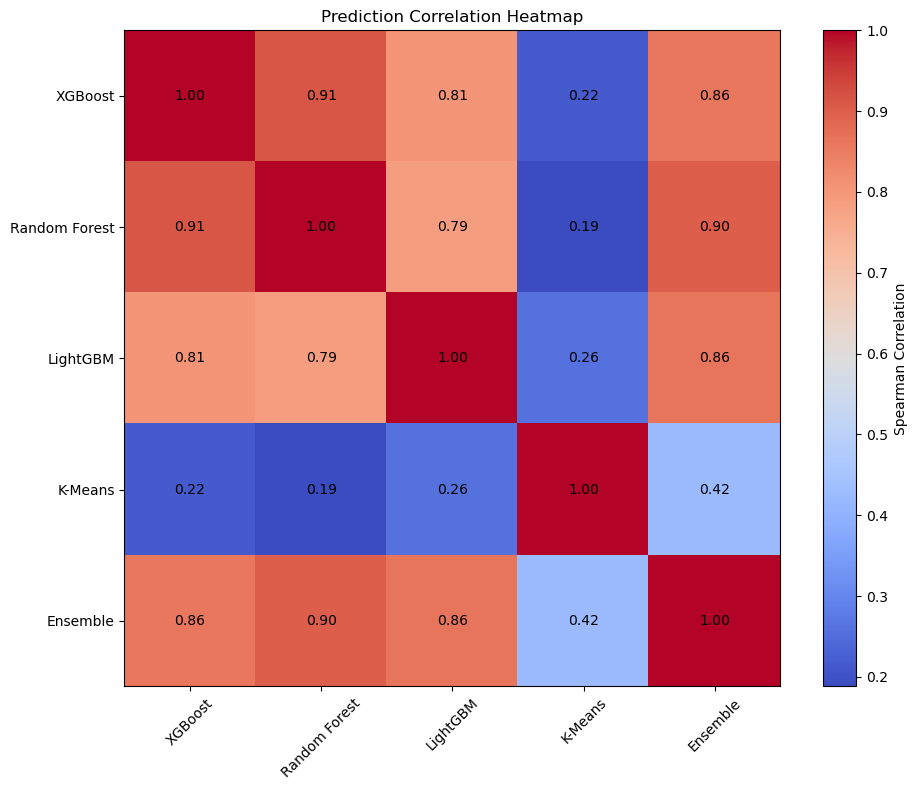

In [13]:
corr_matrix = pd.DataFrame({
    'XGBoost': oof_xgb,
    'Random Forest': oof_rf,
    'LightGBM': oof_lgb,
    'K-Means': oof_kmeans,
    'Ensemble': oof_ensemble
}).corr(method='spearman')

print('\nPrediction Correlation Matrix (Spearman):')
print(corr_matrix)

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Spearman Correlation')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.index)
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')
plt.title('Prediction Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

## Model Performance Analysis

Evaluate model performance.


===== Model Performance Analysis =====
XGBoost - Train AUC: 0.9599, Val AUC: 0.8939, Gap: 0.0661
Random Forest - Train AUC: 1.0000, Val AUC: 0.8896, Gap: 0.1104
LightGBM - Train AUC: 0.9929, Val AUC: 0.8870, Gap: 0.1059
K-Means - Train AUC: 0.5901, Val AUC: 0.5823, Gap: 0.0077
Ensemble - Val AUC: 0.8945


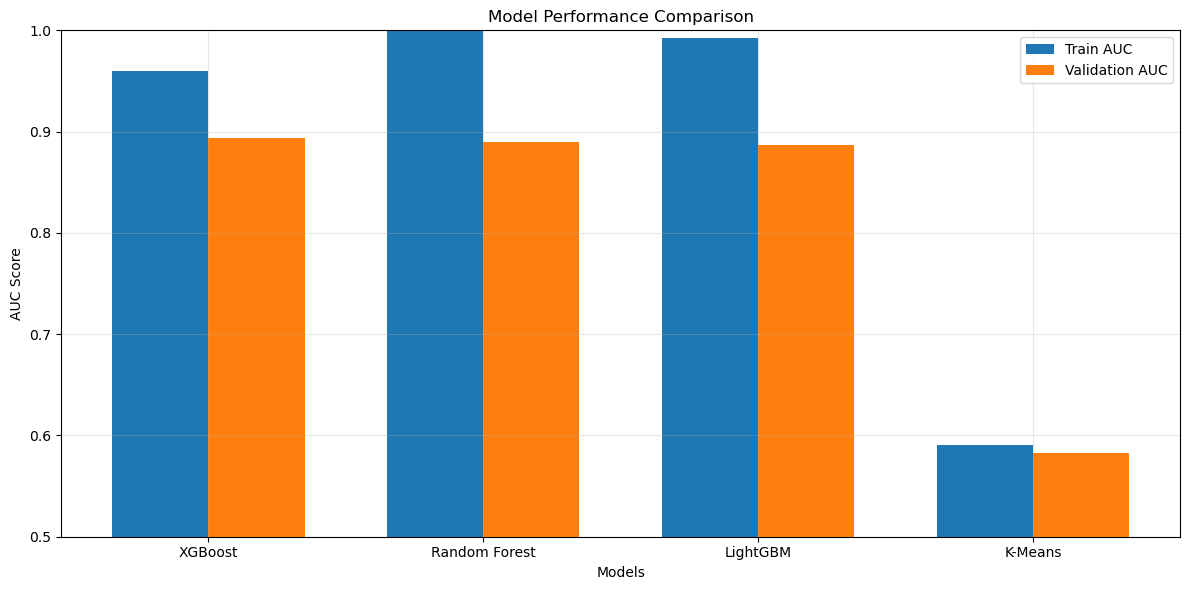

In [14]:
print('\n===== Model Performance Analysis =====')
xgb_mean_train_auc = np.mean(xgb_fold_train_auc)
xgb_mean_val_auc = np.mean(xgb_fold_val_auc)
rf_mean_train_auc = np.mean(rf_fold_train_auc)
rf_mean_val_auc = np.mean(rf_fold_val_auc)
lgb_mean_train_auc = np.mean(lgb_fold_train_auc)
lgb_mean_val_auc = np.mean(lgb_fold_val_auc)
kmeans_mean_train_auc = np.mean(kmeans_fold_train_auc)
kmeans_mean_val_auc = np.mean(kmeans_fold_val_auc)

xgb_overfit_gap = xgb_mean_train_auc - xgb_mean_val_auc
rf_overfit_gap = rf_mean_train_auc - rf_mean_val_auc
lgb_overfit_gap = lgb_mean_train_auc - lgb_mean_val_auc
kmeans_overfit_gap = kmeans_mean_train_auc - kmeans_mean_val_auc

print(f'XGBoost - Train AUC: {xgb_mean_train_auc:.4f}, Val AUC: {xgb_mean_val_auc:.4f}, Gap: {xgb_overfit_gap:.4f}')
print(f'Random Forest - Train AUC: {rf_mean_train_auc:.4f}, Val AUC: {rf_mean_val_auc:.4f}, Gap: {rf_overfit_gap:.4f}')
print(f'LightGBM - Train AUC: {lgb_mean_train_auc:.4f}, Val AUC: {lgb_mean_val_auc:.4f}, Gap: {lgb_overfit_gap:.4f}')
print(f'K-Means - Train AUC: {kmeans_mean_train_auc:.4f}, Val AUC: {kmeans_mean_val_auc:.4f}, Gap: {kmeans_overfit_gap:.4f}')
print(f'Ensemble - Val AUC: {score:.4f}')

plt.figure(figsize=(12, 6))
models = ['XGBoost', 'Random Forest', 'LightGBM', 'K-Means']
train_aucs = [xgb_mean_train_auc, rf_mean_train_auc, lgb_mean_train_auc, kmeans_mean_train_auc]
val_aucs = [xgb_mean_val_auc, rf_mean_val_auc, lgb_mean_val_auc, kmeans_mean_val_auc]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_aucs, width, label='Train AUC')
plt.bar(x + width/2, val_aucs, width, label='Validation AUC')
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.ylim(0.5, 1.0)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()